In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load the dataset
data_path = 'Processed data/data_final_merged.csv'
df = pd.read_csv(data_path)

# Assuming the last column is the target variable
target_col = df.columns[-2]
X = df.drop(columns=[df.columns[0], target_col, df.columns[-1], df.columns[-3]]).values
y = df[target_col].values
print(type(X))
print("Label distribution before SMOTE:", Counter(y))


<class 'numpy.ndarray'>
Label distribution before SMOTE: Counter({0.0: 54, 1.0: 19})


In [3]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)

# Apply PCA
pca = PCA(n_components=40)  # For visualization
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)


# Apply SMOTE
#smote = SMOTE(sampling_strategy=1)
#X_resampled, y_resampled = smote.fit_resample(X_pca, y)
#print(type(X_resampled))
## Ensure y_resampled is a NumPy array
#y_resampled = np.array(y_resampled)
## Check new label distribution
#print("Label distribution after SMOTE:", Counter(y_resampled))

(73, 193)
(73, 40)


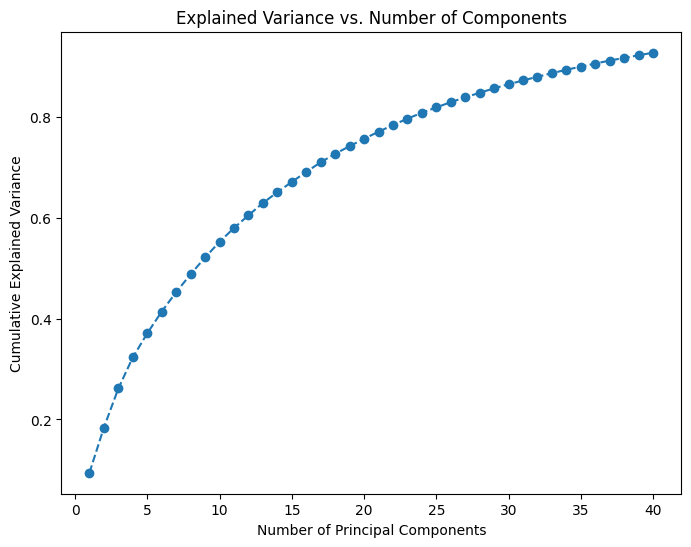

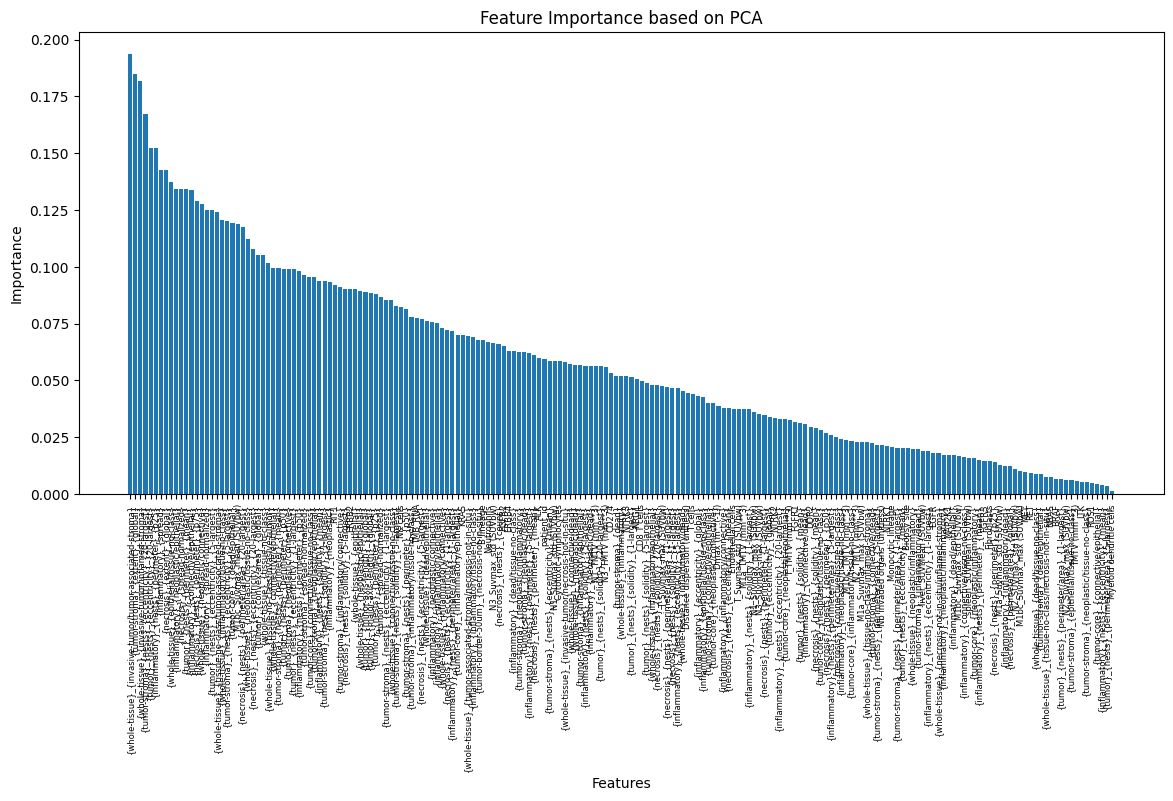

In [4]:
# Explained variance ratio plot
plt.figure(figsize=(8,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Feature importance based on PCA components
feature_importance = np.abs(pca.components_[0])  # First principal component
feature_names = df.drop(columns=[target_col]).columns

# Sort feature importances
sorted_idx = np.argsort(feature_importance)[::-1]
plt.figure(figsize=(14,6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=90, fontsize=6)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance based on PCA')
plt.show()

In [5]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
# Train RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Accuracy: 0.7333333333333333
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      1.00      0.85        11
         1.0       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15



/Users/ccy/anaconda3/envs/cmu16824hw1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ccy/anaconda3/envs/cmu16824hw1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ccy/anaconda3/envs/cmu16824hw1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x


In [10]:
# Instantiate model
model = MLP(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# Training Loop
num_epochs = 40
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
log_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)
    
    # Evaluate
    model.eval()
    test_loss = 0.0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct_test += (predictions == labels).sum().item()
            total_test += labels.size(0)
    
    train_loss_avg = running_loss / len(train_loader)
    test_loss_avg = test_loss / len(test_loader)
    train_accuracy = correct_train / total_train
    test_accuracy = correct_test / total_test
    
    train_losses.append(train_loss_avg)
    test_losses.append(test_loss_avg)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    log_data.append([epoch+1, train_loss_avg, test_loss_avg, train_accuracy, test_accuracy])
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f}, Test Loss: {test_loss_avg:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')

# Save logs
log_df = pd.DataFrame(log_data, columns=['Epoch', 'Train Loss', 'Test Loss', 'Train Accuracy', 'Test Accuracy'])
log_df.to_csv('logs.csv', index=False)


Epoch 1/40 - Train Loss: 0.6458, Test Loss: 0.6386, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 2/40 - Train Loss: 0.6386, Test Loss: 0.6362, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 3/40 - Train Loss: 0.6341, Test Loss: 0.6342, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 4/40 - Train Loss: 0.6235, Test Loss: 0.6319, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 5/40 - Train Loss: 0.6282, Test Loss: 0.6297, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 6/40 - Train Loss: 0.6144, Test Loss: 0.6270, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 7/40 - Train Loss: 0.6100, Test Loss: 0.6238, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 8/40 - Train Loss: 0.6148, Test Loss: 0.6201, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 9/40 - Train Loss: 0.6104, Test Loss: 0.6163, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 10/40 - Train Loss: 0.5959, Test Loss: 0.6121, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 11/40 - Train Loss: 0.5958, Test Loss: 0.6079, Train Acc: 0.7414, Test Acc: 0.7333
Epoch 12/40 - Train Loss: 0.57

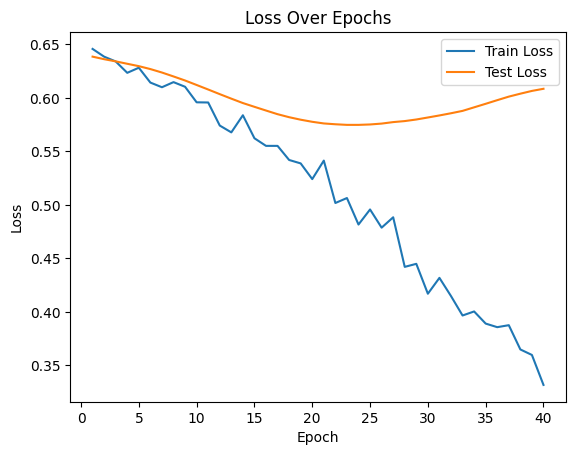

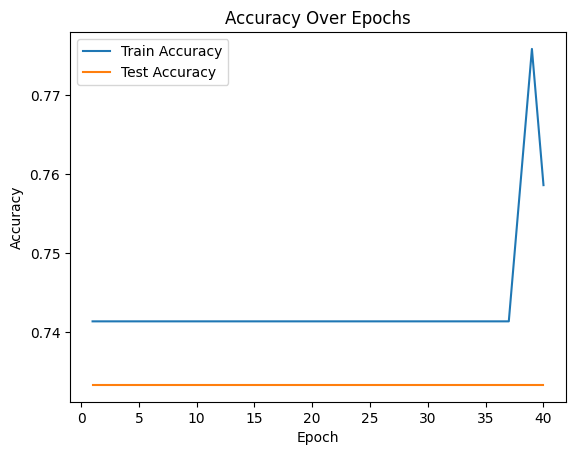

Training complete. Logs saved as logs.csv.


In [11]:
# Plot Loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

print("Training complete. Logs saved as logs.csv.")

